Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [187]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [188]:
n_passengers = np.array(df['Passengers'].values, dtype='float32')
n_passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [189]:
split_index = int(len(n_passengers) * 0.67)
train = n_passengers[:split_index]
val = n_passengers[split_index:]
train.shape, val.shape

((96,), (48,))

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [190]:
import torch

In [191]:
def create_dataset(dataset, lookback):
  x_data = []
  y_data = []

  for i in range(len(dataset) - lookback):
    x_data.append(dataset[i:i+lookback])
    y_data.append([dataset[i+lookback]])
  x = torch.tensor(x_data, dtype=torch.float32)
  y = torch.tensor(y_data, dtype=torch.float32)
  return x, y


In [192]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [193]:
import torch.nn as nn

In [194]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


hidden_size = 50
model = AirModel(hidden_size)
model

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [195]:
x = torch.tensor([[112.]])
x = x.unsqueeze(-1)
x.shape

torch.Size([1, 1, 1])

In [196]:
res = model(x)

In [197]:
res

tensor([[-0.4345]], grad_fn=<AddmmBackward0>)

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [198]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [199]:
data = TensorDataset(X_train, y_train)

In [200]:
batch_size = 8
train_df = DataLoader(data, batch_size, shuffle=True)
sample = next(iter(train_df))
sample

[tensor([[172.],
         [191.],
         [196.],
         [163.],
         [149.],
         [204.],
         [242.],
         [293.]]),
 tensor([[194.],
         [172.],
         [196.],
         [172.],
         [170.],
         [188.],
         [209.],
         [259.]])]

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [201]:
import torch.optim as optim
from tqdm import tqdm

In [202]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [203]:
num_epochs = 2000
losses = []

for epoch in tqdm(range(num_epochs)):

    model.train()

    for X_batch, y_batch in train_df:
        optimizer.zero_grad()

        X_batch = X_batch.unsqueeze(-1)

        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        rmse = torch.sqrt(loss)

        loss.backward()
        optimizer.step()

        losses.append(rmse.item())

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_X = X_train.unsqueeze(-1)
            train_preds = model(train_X)
            train_mse = criterion(train_preds, y_train)
            train_rmse = torch.sqrt(train_mse).item()

            test_X = X_test.unsqueeze(-1)
            test_preds = model(test_X)
            test_mse = criterion(test_preds, y_test)
            test_rmse = torch.sqrt(test_mse).item()

        print(f"Epoch {epoch}: train RMSE = {train_rmse:.4f}, test RMSE = {test_rmse:.4f}")



  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0: train RMSE = 224.0527, test RMSE = 420.3863


  5%|▌         | 104/2000 [00:04<01:07, 27.89it/s]

Epoch 100: train RMSE = 77.8824, test RMSE = 244.9395


 10%|█         | 205/2000 [00:07<00:54, 32.74it/s]

Epoch 200: train RMSE = 72.5035, test RMSE = 228.1810


 15%|█▌        | 305/2000 [00:10<00:58, 29.12it/s]

Epoch 300: train RMSE = 71.3274, test RMSE = 219.8177


 20%|██        | 404/2000 [00:14<01:19, 20.08it/s]

Epoch 400: train RMSE = 71.1722, test RMSE = 216.7995


 25%|██▌       | 504/2000 [00:18<00:50, 29.35it/s]

Epoch 500: train RMSE = 71.1492, test RMSE = 214.9861


 30%|███       | 604/2000 [00:21<00:41, 33.71it/s]

Epoch 600: train RMSE = 71.1494, test RMSE = 215.2988


 35%|███▌      | 705/2000 [00:25<00:45, 28.53it/s]

Epoch 700: train RMSE = 71.1492, test RMSE = 214.9657


 40%|████      | 807/2000 [00:30<00:47, 25.02it/s]

Epoch 800: train RMSE = 71.1492, test RMSE = 214.9720


 45%|████▌     | 906/2000 [00:33<00:37, 29.16it/s]

Epoch 900: train RMSE = 71.1491, test RMSE = 215.0988


 50%|█████     | 1005/2000 [00:36<00:31, 32.02it/s]

Epoch 1000: train RMSE = 71.1495, test RMSE = 214.8932


 55%|█████▌    | 1105/2000 [00:40<00:41, 21.34it/s]

Epoch 1100: train RMSE = 71.1518, test RMSE = 215.6837


 60%|██████    | 1206/2000 [00:44<00:26, 29.86it/s]

Epoch 1200: train RMSE = 71.1492, test RMSE = 215.2383


 65%|██████▌   | 1305/2000 [00:48<00:21, 31.98it/s]

Epoch 1300: train RMSE = 71.1491, test RMSE = 215.0338


 70%|███████   | 1404/2000 [00:54<00:29, 20.45it/s]

Epoch 1400: train RMSE = 71.1493, test RMSE = 215.2690


 75%|███████▌  | 1506/2000 [00:58<00:15, 31.58it/s]

Epoch 1500: train RMSE = 71.1491, test RMSE = 215.1525


 80%|████████  | 1606/2000 [01:02<00:12, 31.37it/s]

Epoch 1600: train RMSE = 71.1492, test RMSE = 215.0049


 85%|████████▌ | 1704/2000 [01:05<00:15, 19.63it/s]

Epoch 1700: train RMSE = 71.1492, test RMSE = 215.1930


 90%|█████████ | 1806/2000 [01:09<00:06, 31.61it/s]

Epoch 1800: train RMSE = 71.1493, test RMSE = 214.9531


 95%|█████████▌| 1905/2000 [01:13<00:03, 27.21it/s]

Epoch 1900: train RMSE = 71.1493, test RMSE = 214.9297


100%|██████████| 2000/2000 [01:16<00:00, 26.07it/s]


**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

In [204]:
import matplotlib.pyplot as plt

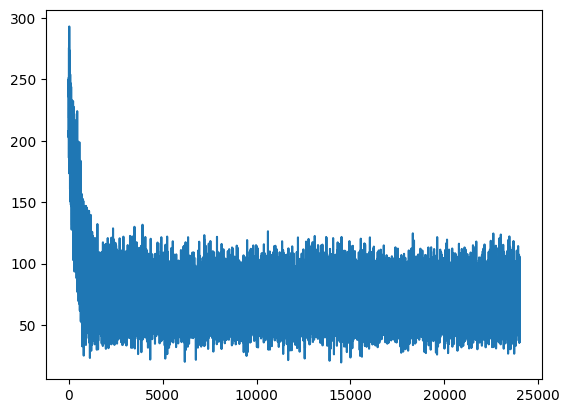

In [205]:
plt.plot(losses);

Виходячи з графіку помилок маємо суттєве зниження RMSE вже після першої епохи. Проте після цього модель вже немає суттєвого покращення.  
Також, відповідно до виведених значень помилок після кожних 100 епох, спостерігаємо що на тренувальних даних значення помилки на багато менше ніж на тестових даних, що може свідчити про деяке переобучення моделі. Отже, модель навилась, проте результати далекі від задовільних.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

[      nan 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435 214.74435
 214.74435 214.74435 214.74435 214.74435 214.74435       nan       nan
      

/tmp/ipython-input-3412271114.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:int(len(n_passengers) * 0.67)] = model(X_tr)[:, -1]
/tmp/ipython-input-3412271114.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[int(len(n_passengers) * 0.67)+lookback:len(timeseries)] = model(X_ts)[:, -1]


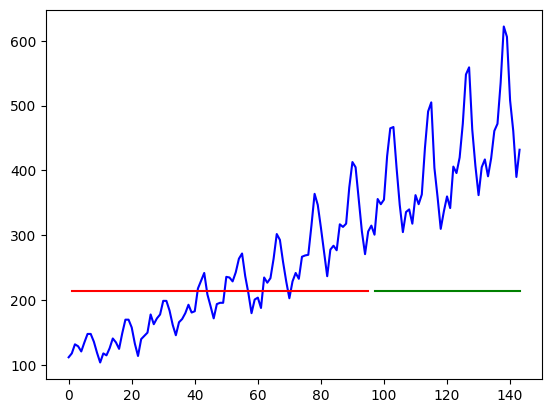

In [206]:
def plot_predicts(timeseries, X_train, X_test, model):
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      X_tr = X_train.unsqueeze(-1)
      train_plot[lookback:int(len(n_passengers) * 0.67)] = model(X_tr)[:, -1]
      print(train_plot)

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      X_ts = X_test.unsqueeze(-1)
      test_plot[int(len(n_passengers) * 0.67)+lookback:len(timeseries)] = model(X_ts)[:, -1]
      print(test_plot)

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(n_passengers, X_train, X_test, model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [211]:
hidden_size = 100
model_2 = AirModel(hidden_size)
model_2

AirModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [212]:
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.01)
num_epochs = 2000
losses = []

for epoch in tqdm(range(num_epochs)):

    model_2.train()

    for X_batch, y_batch in train_df:
        optimizer_2.zero_grad()

        X_batch = X_batch.unsqueeze(-1)

        preds = model_2(X_batch)
        loss = criterion(preds, y_batch)
        rmse = torch.sqrt(loss)

        loss.backward()
        optimizer_2.step()

        losses.append(rmse.item())

    if epoch % 100 == 0:
        model_2.eval()
        with torch.no_grad():
            train_X = X_train.unsqueeze(-1)
            train_preds = model_2(train_X)
            train_mse = criterion(train_preds, y_train)
            train_rmse = torch.sqrt(train_mse).item()

            test_X = X_test.unsqueeze(-1)
            test_preds = model_2(test_X)
            test_mse = criterion(test_preds, y_test)
            test_rmse = torch.sqrt(test_mse).item()

        print(f"Epoch {epoch}: train RMSE = {train_rmse:.4f}, test RMSE = {test_rmse:.4f}")

  0%|          | 6/2000 [00:00<01:19, 25.20it/s]

Epoch 0: train RMSE = 220.8642, test RMSE = 417.1584


  5%|▌         | 105/2000 [00:04<01:22, 23.08it/s]

Epoch 100: train RMSE = 72.6277, test RMSE = 228.6768


 10%|█         | 203/2000 [00:09<02:01, 14.82it/s]

Epoch 200: train RMSE = 72.3351, test RMSE = 227.3305


 15%|█▌        | 304/2000 [00:13<01:12, 23.42it/s]

Epoch 300: train RMSE = 71.1856, test RMSE = 217.2356


 20%|██        | 403/2000 [00:17<01:08, 23.42it/s]

Epoch 400: train RMSE = 71.1491, test RMSE = 215.0484


 25%|██▌       | 502/2000 [00:22<01:42, 14.55it/s]

Epoch 500: train RMSE = 71.1492, test RMSE = 215.2256


 30%|███       | 603/2000 [00:27<01:00, 23.11it/s]

Epoch 600: train RMSE = 71.1491, test RMSE = 215.0751


 35%|███▌      | 705/2000 [00:31<00:48, 26.55it/s]

Epoch 700: train RMSE = 71.1491, test RMSE = 215.0370


 40%|████      | 803/2000 [00:36<00:52, 22.96it/s]

Epoch 800: train RMSE = 71.1491, test RMSE = 215.0336


 45%|████▌     | 905/2000 [00:40<00:49, 22.26it/s]

Epoch 900: train RMSE = 71.1495, test RMSE = 214.8782


 50%|█████     | 1004/2000 [00:44<00:46, 21.33it/s]

Epoch 1000: train RMSE = 71.1494, test RMSE = 214.9058


 55%|█████▌    | 1104/2000 [00:50<00:41, 21.69it/s]

Epoch 1100: train RMSE = 71.1491, test RMSE = 215.0500


 60%|██████    | 1203/2000 [00:54<00:35, 22.36it/s]

Epoch 1200: train RMSE = 71.1496, test RMSE = 215.3435


 65%|██████▌   | 1302/2000 [00:58<00:32, 21.62it/s]

Epoch 1300: train RMSE = 71.1494, test RMSE = 215.3066


 70%|███████   | 1406/2000 [01:03<00:21, 27.01it/s]

Epoch 1400: train RMSE = 71.1491, test RMSE = 215.0880


 75%|███████▌  | 1505/2000 [01:07<00:19, 25.19it/s]

Epoch 1500: train RMSE = 71.1494, test RMSE = 215.2955


 80%|████████  | 1602/2000 [01:12<00:23, 16.92it/s]

Epoch 1600: train RMSE = 71.1495, test RMSE = 215.3239


 85%|████████▌ | 1704/2000 [01:17<00:10, 27.23it/s]

Epoch 1700: train RMSE = 71.1491, test RMSE = 215.1037


 90%|█████████ | 1806/2000 [01:21<00:08, 24.16it/s]

Epoch 1800: train RMSE = 71.1491, test RMSE = 215.0281


 95%|█████████▌| 1903/2000 [01:25<00:05, 17.92it/s]

Epoch 1900: train RMSE = 71.1510, test RMSE = 214.6199


100%|██████████| 2000/2000 [01:30<00:00, 22.17it/s]


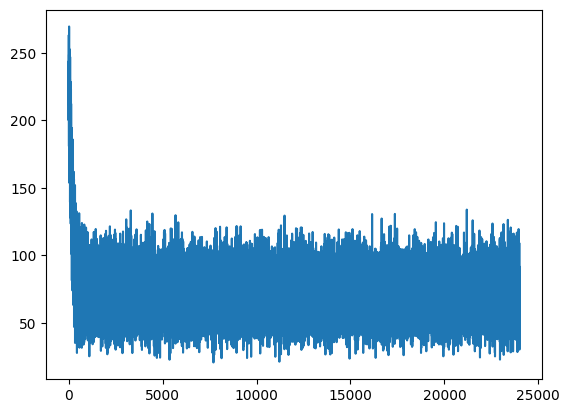

In [213]:
plt.plot(losses);

Після збільшення hidden_size до 100 результати моделі не поліпшились.